#Variational Autoencoders for Collaborative Filtering in Restaurant Recommendation Systems
Recommender System Course Project - Section A2 - Students:
* Ahad Alsulami | 2008263
* Shatha Alotaibi | 2006590
* Reema Albishri | 2007876

## Import Libraries

In [4]:
!pip install bottleneck

In [5]:
# import libraries
import pandas as pd
import numpy as np
import os
import sys
import tensorflow.compat.v1 as tf
from scipy import sparse
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
sn.set()
import bottleneck as bn
tf.disable_v2_behavior()

## Data Preprocessing

In this part, we will read the restaurants reviews dataset and preprocess by implementing:
- Handle missings values
- Convert to numeric
- Create IDs for users and items


In [6]:
# read data
reviews_data = pd.read_csv('/content/Restaurant reviews.csv')

In [7]:
# print data
reviews_data.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


#### Dataset preprocess:

In [8]:
# function to check missing values
'''
This function has been taken from RS Lab 8 to check if we have any missing
values in our dataset. It will help us handling them if there was any.
'''
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
         #mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [9]:
# check if there are missing values using the above function
missing_zero_values_table(reviews_data)

Your selected dataframe has 7 columns and 10000 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Review,0,45,0.4,45,0.4,object
Reviewer,0,38,0.4,38,0.4,object
Rating,0,38,0.4,38,0.4,object
Metadata,0,38,0.4,38,0.4,object
Time,0,38,0.4,38,0.4,object


In [10]:
# handle missing values
reviews_data = reviews_data.fillna(0)
missing_zero_values_table(reviews_data)

Your selected dataframe has 7 columns and 10000 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [11]:
# print information about the dataset
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    10000 non-null  object
 2   Review      10000 non-null  object
 3   Rating      10000 non-null  object
 4   Metadata    10000 non-null  object
 5   Time        10000 non-null  object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [12]:
# some of the ratings included the word 'Like' so we change it to 4 rating
# (1: Hate, 2: Dislike, 3: Neutral, 4: Like, 5: Love)
reviews_data['Rating'] = reviews_data['Rating'].replace('Like', '4')

# convert rating column from object to numeric
reviews_data['Rating'] = pd.to_numeric(reviews_data['Rating'])

In [71]:
'''
يمكن ما نحتاجه
'''
# split the metadata into no. reviews and no. followers
reviews_data["Metadata"] = reviews_data["Metadata"].astype("str")
reviews_data[['No. Reviews','No. Followers']] = reviews_data["Metadata"].str.split("," , expand=True)
reviews_data.drop('Metadata', inplace=True, axis=1)
reviews_data.head()

,Restaurant,Reviewer,Review,Rating,Time,Pictures,RestaurantID,ReviewerID,No. Reviews,No. Followers
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5.0,5/25/2019 15:54,0,0,0,1 Review,2 Followers
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5.0,5/25/2019 14:20,0,0,1,3 Reviews,2 Followers
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5.0,5/24/2019 22:54,0,0,2,2 Reviews,3 Followers
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5.0,5/24/2019 22:11,0,0,3,1 Review,1 Follower
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5.0,5/24/2019 21:37,0,0,4,3 Reviews,2 Followers


In [72]:
'''
يمكن ما نحتاجه
'''
# convert the columns from objects into numerics
reviews_data['No. Reviews'] = pd.to_numeric(reviews_data['No. Reviews'].str.replace(r'\D+', ''))
reviews_data['No. Followers'] = pd.to_numeric(reviews_data['No. Followers'].str.replace(r'\D+', ''))

<ipython-input-72-481e516ed970>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_data['No. Reviews'] = pd.to_numeric(reviews_data['No. Reviews'].str.replace(r'\D+', ''))
<ipython-input-72-481e516ed970>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  reviews_data['No. Followers'] = pd.to_numeric(reviews_data['No. Followers'].str.replace(r'\D+', ''))


In [73]:
# check changing types
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant     10000 non-null  object 
 1   Reviewer       10000 non-null  object 
 2   Review         10000 non-null  object 
 3   Rating         10000 non-null  float64
 4   Time           10000 non-null  object 
 5   Pictures       10000 non-null  int64  
 6   RestaurantID   10000 non-null  int64  
 7   ReviewerID     10000 non-null  int64  
 8   No. Reviews    10000 non-null  int64  
 9   No. Followers  8384 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 781.4+ KB


In [16]:
# create dictionary to store restaurants names and their IDs
rest_name_mapping = {}
rest_name_count = 0

# assign IDs to names while keeping track of repeated names
for name in reviews_data['Restaurant']:
    if name not in rest_name_mapping:
        rest_name_mapping[name] = rest_name_count
        rest_name_count += 1
    reviews_data['RestaurantID'] = reviews_data['Restaurant'].map(rest_name_mapping)

In [17]:
# create dictionary to store reviewers names and their IDs
rev_name_mapping = {}
rev_name_count = 0

# assign IDs to names while keeping track of repeated names
for name in reviews_data['Reviewer']:
    if name not in rev_name_mapping:
        rev_name_mapping[name] = rev_name_count
        rev_name_count += 1
    reviews_data['ReviewerID'] = reviews_data['Reviewer'].map(rev_name_mapping)

#### Find implicit feedback
We will create a matrix between reviewers and restaurant. This user-by-item interaction matrix is the click matrix. and the number of clicks is one of the implicit feedacks types.

In [18]:
# create a function that works as a counter
'''
we will use it to count the:
- number of users
- number of items
'''
def count(data, column):
  counter = data[[column]].groupby(column, as_index=False)
  i = counter.size()
  return i

In [19]:
# create a function that calculate number of clicks
'''
The function filters the dataset to only include (user, item, ratings) where
the item has been clicked on by at least `min_uc` users and the user has clicked
on at least `min_ic` items.
the function returns:
- data: the filtered dataset
- userCount: containing the number of restaurants clicked on by each reviewer.
- itemCount: containing the number of reviewer who have clicked on each item.
only keep items that are clicked on by at least 5 users
'''
def filter(data, min_ic=5, min_uc=0):
  # keep items that were clicked by at least min_uc users
  if min_uc > 0:
    itemCount = count(data, 'RestaurantID')
    restaurants = itemCount[itemCount >= min_uc].index
    data = data[data['RestaurantID'].isin(restaurants)]

  # keep users who clicked on at least min_uc
  if min_ic > 0:
    userCount = count(data, 'ReviewerID')
    reviewers = userCount[userCount >= min_ic].index
    data = data[data['ReviewerID'].isin(reviewers)]

  # update the numbers after filtering
  userCount, itemCount = count(data, 'ReviewerID'), count(data, 'RestaurantID')

  return data, userCount, itemCount

In [20]:
data, user_activity, item_popularity = filter(reviews_data)

In [21]:
# check on the data (sparsity & general info)
sparsity = 1. * data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])
print("After filtering, there are %d reviewing events from %d users and %d restaurants (sparsity: %.3f%%)" %
      (data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 10000 reviewing events from 7447 users and 100 restaurants (sparsity: 1.343%)


#### Split into `train`, `test`, and `validate`
We will perform data splitting by defining three sets of users:
- train users are used to train the model.
- validation users are used to tune the model's hyperparameters.
- test users are used to evaluate the model's performance.
we will assign a number of heldout users to `test` and `validate` sets and the rest will be for `train` set.

And to ensure equal seperation we will shuffle the users IDs as our first step

In [22]:
'''
this part shuffles the order of the unique user IDs `unique_uid`
'''
# assign the unique user IDs from the `user_activity` to the variable `unique_uid`
unique_uid = user_activity.index
# sets the seed for the random number to ensure the same sequence.
np.random.seed(50)
# shuffle the order of the users
shuffleID = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[shuffleID]

In [23]:
'''
this part defines the sets
'''
# the number of users and the number of users to hold out for splitting
n_users = unique_uid.size
n_heldout_users = 2000

train = unique_uid[:(n_users - n_heldout_users * 2)]
validate = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
test = unique_uid[(n_users - n_heldout_users):]

In [24]:
# select subset of data where the `ReviewerID` values belong to the `train` set
train_data = reviews_data.loc[reviews_data['ReviewerID'].isin(train)]

In [25]:
# extract the unique `RestaurantID` from the train_data
# means (restaurant associated with user interactions)
unique_iid = pd.unique(train_data['RestaurantID'])

In [26]:
# dictionaries to map unique IDs to indices
# can be used to represent both IDs in other data structures, such as matrices
restaurant2id = dict((rid, i) for (i, rid) in enumerate(unique_iid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [27]:
'''
this part will create a directory to save a list of unique IDs into a file
'''
# initialize the path of the directory that will be created
dir = os.path.join('/content', 'files')

# create the directory if it wasn't existed
if not os.path.exists(dir):
    os.makedirs(dir)

# create and write into the text file
with open(os.path.join(dir, 'movies IDs.txt'), 'w') as f:
    for iid in unique_iid:
        f.write('%s\n' % iid)

In [28]:
'''
this function splits the dataset into `train` and `test` sets
based on a specified proportion of items for each user
'''
def split_train_test_proportion(data, prop=0.2):
  # creates a group of items for each user in the dataset
  dataGrouped = data.groupby('ReviewerID')

  # create empty lists for `train` and `test` sets
  train_list, test_list = list(), list()

  # seed the random number to ensure the same sequence
  np.random.seed(50)

  # iterates over the groups of items
  for i, (_, group) in enumerate(dataGrouped):
    n_items = len(group) # check number if items (restaurant) for each user

    # if the number of items is greater than or equal to 5, a random sample
    # of items is selected for the `test` set
    if n_items >= 5:
      idx = np.zeros(n_items, dtype='bool')

      # The size of the sample is determined by multiplying the number of items
      # by the prop value. the selected items are marked using an array of boolean values.
      idx[np.random.choice(n_items, size=int(prop * n_items), replace=False).astype('int64')] = True

      # add items to `train` and `test` lists:
      # items are not selected for the test set are added to the `train_list`
      # items are selected for the test set are added to the `test_list`
      train_list.append(group[np.logical_not(idx)])
      test_list.append(group[idx])

    #  if the number of items is less than 5, add items to the `train` list
    else:
      train_list.append(group)

    # print progress. for every 200 users, a message is printed to indicate
    # the number of users that have been sampled
    if i % 200 == 0:
      print("%d users sampled" % i)
      sys.stdout.flush()

  data_train = pd.concat(train_list)
  data_test = pd.concat(test_list)

  return data_train, data_test

In [29]:
# only include rows where the IDs values are present in the validate set
valid_data = reviews_data.loc[reviews_data['ReviewerID'].isin(validate)]
valid_data = valid_data.loc[valid_data['RestaurantID'].isin(unique_iid)]

# split validation data
valid_data_train, valid_data_test = split_train_test_proportion(valid_data)

0 users sampled
200 users sampled
400 users sampled
600 users sampled
800 users sampled
1000 users sampled
1200 users sampled
1400 users sampled
1600 users sampled
1800 users sampled


In [30]:
# only include rows where the IDs values are present in the test set
test_data = reviews_data.loc[reviews_data['ReviewerID'].isin(test)]
test_data = test_data.loc[test_data['RestaurantID'].isin(unique_iid)]

# split testing data
test_data_train, test_data_test = split_train_test_proportion(test_data)

0 users sampled
200 users sampled
400 users sampled
600 users sampled
800 users sampled
1000 users sampled
1200 users sampled
1400 users sampled
1600 users sampled
1800 users sampled


In [31]:
'''
takes a dataset and returns a new DataFrame with the ReviewrsId and
RestaurantId columns, by iterating over the IDs columns of the data and using
the map() function to apply the dictionaries to each IDs columns
'''
def numerize(Data):
    uid = list(map(lambda x: profile2id[x], Data['ReviewerID']))
    iid = list(map(lambda x: restaurant2id[x], Data['RestaurantID']))
    return pd.DataFrame(data={'userid': uid, 'itemid': iid}, columns=['userid', 'itemid'])

In [32]:
# numerize data and save it as csv file

# train
trainData = numerize(train_data)
trainData.to_csv(os.path.join(dir, 'train.csv'), index=False)

# validate
valid_data_tr = numerize(valid_data_train)
valid_data_tr.to_csv(os.path.join(dir, 'validation_train.csv'), index=False)

valid_data_te = numerize(valid_data_test)
valid_data_te.to_csv(os.path.join(dir, 'validation_test.csv'), index=False)

# test
test_data_tr = numerize(test_data_train)
test_data_tr.to_csv(os.path.join(dir, 'test_train.csv'), index=False)

test_data_te = numerize(test_data_test)
test_data_te.to_csv(os.path.join(dir, 'test_test.csv'), index=False)

## Build Models


We define two related models: denoising autoencoder with multinomial likelihood (Multi-DAE in the paper) and partially-regularized variational autoencoder with multinomial likelihood (Multi-VAE^{PR} in the paper).

#### **MultiDAE class**
A multi-layer autoencoder is a type of neural network that is used to learn a compressed representation of the input data. This compressed representation is also known as a latent representation, and it captures the underlying patterns and relationships within the data.

The autoencoder consists of two main parts: an encoder and a decoder. The encoder takes the input data and compresses it into a latent representation. The decoder then takes the latent representation and reconstructs the original input data.

  * `p_dims:` Defines the dimensions of the input layer and the p-encoder network
  * `q_dims (optional):` Defines the dimensions of the q-decoder network. If not provided, it defaults to the reverse order of p_dims.
  * `lam:` Regularization parameter (lambda) for l2 regularization.
  * `lr:` Learning rate for the Adam optimizer.
  * `random_seed:` Optional random seed for weight initialization.

In [33]:
'''
this part is for the building of the first model
(Denoising Autoencoder with Multinomial Likelihood - Multi DAE)
which implements a multi-layer autoencoder neural network architecture.
the autoencoder aims to learn a compressed representation of the input data,
capturing the underlying patterns and relationships within the data.
'''
class MultiDAE(object):
  # class initialization (initializes the autoencoder)
  def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
    self.p_dims = p_dims

    # sets self.q_dims to the reverse order of p_dims if not provided
    if q_dims is None:
      self.q_dims = p_dims[::-1]
    # checks that the dimensions of the autoencoder are equal and that the latent dimension is consistent between the p- and q-networks
    else:
      assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
      assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
      self.q_dims = q_dims

    self.dims = self.q_dims + self.p_dims[1:]
    self.lam = lam
    self.lr = lr
    self.random_seed = random_seed
    self.construct_placeholders()

# -----
  # creates two placeholders
  def construct_placeholders(self):
    # this placeholder holds the input data, which has a shape of (batch_size, input_dimension)
    self.input_ph = tf.placeholder(
        dtype=tf.float32, shape=[None, self.dims[0]])
    # this placeholder holds the dropout probability, which is used for regularization, its default value is 1.0 no dropout is applied
    self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

# -----

  # constructs the entire graph of the autoencoder, including the encoder,
  # decoder, loss function, optimizer, and summary statistics
  def build_graph(self):
    # call the `construct_weights` method to initializ weights & biases of the autoencoder
    self.construct_weights()

    # call the `forward_pass` method, which performs the forward pass through
    # the autoencoder and returns a saver object and the logits (output of the final layer) of the autoencoder
    saver, logits = self.forward_pass()

    # logits are passed through the tf.nn.log_softmax function to compute the log softmax values
    log_softmax_var = tf.nn.log_softmax(logits)

    # per-user average negative log-likelihood
    # negative log-likelihood (neg_ll) is computed by multiplying the log softmax values with the input and taking the mean across the batch
    neg_ll = -tf.reduce_mean(tf.reduce_sum(
        log_softmax_var * self.input_ph, axis=1))

    # apply L2 regularization to weights and summing them
    reg = tf.keras.regularizers.l2(l2=self.lam)
    reg_var = tf.reduce_sum([reg(w) for w in self.weights])

    # loss is the sum of the negative log-likelihood and two times the regularization term
    # tensorflow l2 regularization multiply 0.5 to the l2 norm
    # multiply 2 so that it is back in the same scale
    loss = neg_ll + 2 * reg_var

    # AdamOptimizer is used to minimize the loss
    train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

    # add summary statistics
    # summary statistics can be used to monitor the training process of the autoencoder
    tf.summary.scalar('negative_multi_ll', neg_ll)
    tf.summary.scalar('loss', loss)
    merged = tf.summary.merge_all() # merge the summaries

    return saver, logits, loss, train_op, merged

# -----

  def forward_pass(self):
    # construct forward graph
    # ensures that the input vectors have unit length.
    h = tf.nn.l2_normalize(self.input_ph, 1)

    # passed through a dropout layer helps prevent overfitting
    h = tf.nn.dropout(h, self.keep_prob_ph)

    # iterates over the weights and biases of each layer in the autoencoder
    for i, (w, b) in enumerate(zip(self.weights, self.biases)):
      #  input tensor h is multiplied by the weight matrix w and then added to the bias vector b
      h = tf.matmul(h, w) + b

      # checks if the current layer is not the last layer (i.e., not the output layer)
      # If it's not the last layer, the next step is executed.
      if i != len(self.weights) - 1:
        # output tensor h from the previous layer is passed through the hyperbolic tangent (tanh) activation function using tf.nn.tanh. This introduces non-linearity into the autoencoder, allowing it to learn more complex representations
        h = tf.nn.tanh(h)

    return tf.train.Saver(), h

# -----

# method is responsible for initializing the weights and biases of the autoencoder
  def construct_weights(self):
    # Initialize empty lists to store the weight matrices and bias vectors of each layer
    self.weights = []
    self.biases = []

    # define weights
    # iterates over the dimensions of the layers in the autoencoder, except for the last dimension (output dimension)
    for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
      # Generate unique names for the weight and bias variables of the current layer using the current layer index
      weight_key = "weight_{}to{}".format(i, i+1)
      bias_key = "bias_{}".format(i+1)

      # initializes the weight matrix of the current layer
      # weight matrix is initialized using the Glorot normal initializer (tf.keras.initializers.glorot_normal), which is a commonly used initializer for neural networks. It helps with proper weight initialization and reduces the likelihood of vanishing or exploding gradients.
      # seed parameter of the initializer is set to self.random_seed for reproducibility
      self.weights.append(tf.get_variable(
          # weight matrix is named with weight_key
          name=weight_key, shape=[d_in, d_out],
          initializer=tf.keras.initializers.glorot_normal(
              seed=self.random_seed)))

      # bias vector is initialized using a truncated normal initializer (tf.truncated_normal_initializer) with a standard deviation of 0.001. This initializes the biases with small random values close to zero
      self.biases.append(tf.get_variable(
          name=bias_key, shape=[d_out],
          initializer=tf.truncated_normal_initializer(
              stddev=0.001, seed=self.random_seed)))

      # add summary stats
      tf.summary.histogram(weight_key, self.weights[-1])
      tf.summary.histogram(bias_key, self.biases[-1])

#### **MultiVAE class**
A variational autoencoder is a type of generative model that learns to encode and decode data. It consists of an encoder network that maps input data to a latent space, and a decoder network that reconstructs the input data from the latent space. The VAE is trained to maximize the evidence lower bound (ELBO), which is a trade-off between the reconstruction accuracy and the regularization of the latent space.

The code defines a class named MultiVAE that extends the MultiDAE class. The MultiDAE class likely represents a multi-layer denoising autoencoder (DAE) used as a pretraining step for the VAE

In [34]:
class MultiVAE(MultiDAE):

  def construct_placeholders(self):
    # calls the construct_placeholders method of the parent class, MultiDAE, to create the base placeholders.
    # Additionally, it creates two extra placeholders: is_training_ph for specifying whether the model is in training mode,
    # and anneal_ph for controlling the annealing factor used in the VAE loss function
    super(MultiVAE, self).construct_placeholders()
    # placeholders with default values when scoring
    self.is_training_ph = tf.placeholder_with_default(0., shape=None)
    self.anneal_ph = tf.placeholder_with_default(1., shape=None)

#-----

  # onstructs the computational graph for the VAE. It initializes the weights and biases of the VAE, performs the forward pass, calculates the VAE loss, creates a training operation, and adds summary statistics for monitoring during training.
  def build_graph(self):
    self._construct_weights()
    # KL Divergence is essential to measure the similarity or dissimilarity between probability distributions
    saver, logits, KL = self.forward_pass()
    log_softmax_var = tf.nn.log_softmax(logits)
    # multiplying the log probabilities with the input placeholder (self.input_ph), summing across the last axis, and taking the negative mean
    neg_ll = -tf.reduce_mean(tf.reduce_sum(
        log_softmax_var * self.input_ph,
        axis=-1))
    # apply regularization to weights
    # reg = l2_regularizer(self.lam)
    reg = tf.keras.regularizers.l2(l2=self.lam)
    reg_var = tf.reduce_sum([reg(w) for w in self.weights_q + self.weights_p])
    # reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
    # tensorflow l2 regularization multiply 0.5 to the l2 norm
    # multiply 2 so that it is back in the same scale

    # final VAE loss (neg_ELBO) is the sum of the negative log-likelihood, annealed KL divergence (multiplied by self.anneal_ph), and twice the regularization term. It is used as the objective to minimize during training
    neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
    train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

    # add summary statistics
    tf.summary.scalar('negative_multi_ll', neg_ll)
    tf.summary.scalar('KL', KL)
    tf.summary.scalar('neg_ELBO_train', neg_ELBO)
    merged = tf.summary.merge_all()

    return saver, logits, neg_ELBO, train_op, merged

#-----

  # defines the computation graph for the encoder (q-network) of the VAE.
  def q_graph(self):
    mu_q, std_q, KL = None, None, None
    h = tf.nn.l2_normalize(self.input_ph, 1)
    h = tf.nn.dropout(h, self.keep_prob_ph)

    # iterates over the weights (self.weights_q) and biases (self.biases_q) of the encoder layers
    for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
      h = tf.matmul(h, w) + b
      # If it's not the last layer, it applies the hyperbolic tangent activation function (tf.nn.tanh) to the output.
      if i != len(self.weights_q) - 1:
        h = tf.nn.tanh(h)

      # For the last layer, it splits the output into two parts: mu_q and logvar_q.
      # mu_q represents the mean of the learned latent variables,
      # and logvar_q represents the logarithm of the variance of the latent variables.
      # The standard deviation (std_q) is computed as the exponential of half the logvar_q.
      # KL divergence (KL) is calculated using the formula for the Kullback-Leibler divergence between the approximate posterior distribution and the prior distribution. It measures the difference between these two distributions.
      else:
        mu_q = h[:, :self.q_dims[-1]]
        logvar_q = h[:, self.q_dims[-1]:]
        std_q = tf.exp(0.5 * logvar_q)
        KL = tf.reduce_mean(tf.reduce_sum(
            0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))

    return mu_q, std_q, KL

#------

  # method defines the computation graph for the decoder (p-network) of the VAE
  def p_graph(self, z):
    # takes the latent variables z as input and processes them through the decoder layers defined by self.weights_p and self.biases_p
    h = z

    # Similar to the encoder, it performs matrix multiplications and applies the hyperbolic tangent activation function to the intermediate layers. The output of the last layer is returned
    for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
      h = tf.matmul(h, w) + b

      if i != len(self.weights_p) - 1:
        h = tf.nn.tanh(h)

    return h

#-----

  def forward_pass(self):
    # q-network
    mu_q, std_q, KL = self.q_graph()
    # generates a random noise tensor (epsilon) with the same shape as std_q using tf.random_normal. The noise is scaled by std_q and added to mu_q to obtain sampled_z, which represents a sample from the approximate posterior distribution.
    epsilon = tf.random_normal(tf.shape(std_q))
    # sampled_z through the decoder (p_graph) to obtain the logits, which are the outputs of the generative model
    sampled_z = mu_q + self.is_training_ph * epsilon * std_q

    # p-network
    logits = self.p_graph(sampled_z)

    return tf.train.Saver(), logits, KL

#-----

  # initializes the weights and biases of the encoder and decoder networks. It creates weight and bias variables for each layer using Glorot normal initialization and truncated normal initialization, respectively. It also adds histogram summaries for the weights and biases to monitor their distributions during training.
  def _construct_weights(self):
    self.weights_q, self.biases_q = [], []

    for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
      if i == len(self.q_dims[:-1]) - 1:
        # we need two sets of parameters for mean and variance,
        # respectively
        d_out *= 2
        weight_key = "weight_q_{}to{}".format(i, i+1)
        bias_key = "bias_q_{}".format(i+1)

        self.weights_q.append(tf.get_variable(
            name=weight_key, shape=[d_in, d_out],
            initializer=tf.keras.initializers.glorot_normal(
                seed=self.random_seed)))

        self.biases_q.append(tf.get_variable(
            name=bias_key, shape=[d_out],
            initializer=tf.truncated_normal_initializer(
                stddev=0.001, seed=self.random_seed)))

        # add summary stats
        tf.summary.histogram(weight_key, self.weights_q[-1])
        tf.summary.histogram(bias_key, self.biases_q[-1])

    self.weights_p, self.biases_p = [], []

    for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
      weight_key = "weight_p_{}to{}".format(i, i+1)
      bias_key = "bias_p_{}".format(i+1)
      self.weights_p.append(tf.get_variable(
          name=weight_key, shape=[d_in, d_out],
          initializer=tf.keras.initializers.glorot_normal(
              seed=self.random_seed)))

      self.biases_p.append(tf.get_variable(
          name=bias_key, shape=[d_out],
          initializer=tf.truncated_normal_initializer(
              stddev=0.001, seed=self.random_seed)))

      # add summary stats
      tf.summary.histogram(weight_key, self.weights_p[-1])
      tf.summary.histogram(bias_key, self.biases_p[-1])

## Training/validation data, hyperparameters
Load the pre-processed training and validation data

In [35]:
'''
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)
'''
unique_iid = list()
with open(os.path.join(dir, 'movies IDs.txt'), 'r') as f:
    for line in f:
        unique_iid.append(line.strip())

n_items = len(unique_iid)
n_items

100

In [36]:
'''
a function called load_train_data that takes a CSV file path as input and returns a sparse matrix representing the train data
'''
def load_train_data(csv_file):
  tp = pd.read_csv(csv_file)
  n_users = tp['userid'].max() + 1

  rows, cols = tp['userid'], tp['itemid']
  data = sparse.csr_matrix((np.ones_like(rows),
                          (rows, cols)), dtype='float64',
                           shape=(n_users, n_items))
  return data

In [37]:
training_data = load_train_data(os.path.join(dir, 'train.csv'))
training_data

<3447x100 sparse matrix of type '<class 'numpy.float64'>'
	with 4554 stored elements in Compressed Sparse Row format>

In [38]:
'''
 that takes two CSV file paths as input and returns a tuple containing two sparse matrices: data_tr (train data) and data_te (test data).
'''
def load_valid_data(csv_file_train, csv_file_test):
    tp_tr = pd.read_csv(csv_file_train)
    tp_te = pd.read_csv(csv_file_test)

    start_idx = min(tp_tr['userid'].min(), tp_te['userid'].min())
    end_idx = max(tp_tr['userid'].max(), tp_te['userid'].max())

    rows_train, cols_train = tp_tr['userid'] - start_idx, tp_tr['itemid']
    rows_test, cols_test = tp_te['userid'] - start_idx, tp_te['itemid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_train),
                             (rows_train, cols_train)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_test),
                             (rows_test, cols_test)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [39]:
vad_data_tr, vad_data_te = load_valid_data(os.path.join(dir, 'validation_train.csv'),
                                           os.path.join(dir, 'validation_test.csv'))

In [40]:
vad_data_tr

<2000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 2560 stored elements in Compressed Sparse Row format>

##### Set up training hyperparameters

In [351]:
'''
This code defines variables related to the training and validation data, batch sizes, and annealing parameters.
'''
# train
#  the number of training examples (N) from the shape of the train_data matrix
N = training_data.shape[0]
idxlist = list(range(N))
# sets the training batch size
batch_size = 3000
# Calculates the number of batches per epoch (batches_per_epoch) by dividing the total number of training examples (N) by the training batch size (batch_size) and rounding up using np.ceil
batches_per_epoch = int(np.ceil(float(N) / batch_size))

# valid
N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)
# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# anneal
# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

##### Evaluate function: Normalized discounted cumulative gain (NDCG@k) and Recall@k

In [275]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=99):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])

    # print('Computing dgc / idgc with ' + str(DCG) + ' / ' + str(IDCG))

    return DCG / (IDCG + 1e-6)

In [276]:
def Recall_at_k_batch(X_pred, heldout_batch, k=50):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / (np.minimum(k, X_true_binary.sum(axis=1)) + 1e-6)
    return recall

#### Train a Multi-VAE

In [378]:
p_dims = [80, 100, n_items]

In [379]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=100)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [380]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

Set up logging and checkpoint directory

- Change all the logging directory and checkpoint directory to somewhere of your choice
- Monitor training progress using tensorflow by: `tensorboard --logdir=$log_dir`

In [381]:
log_dir = '/content/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /content/VAE_anneal200.0K_cap2.0E-01/I-100-80-100-I


In [382]:
chkpt_dir = '/content/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir)

print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /content/VAE_anneal200.0K_cap2.0E-01/I-100-80-100-I


In [383]:
n_epochs = 10000

In [384]:
ndcgs_vad = []


with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0

    for epoch in tqdm(range(n_epochs)):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = training_data[idxlist[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')

            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap

            feed_dict = {vae.input_ph: X,
                         vae.keep_prob_ph: 0.5,
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % (N // batch_size) == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train,
                                           global_step=epoch * batches_per_epoch + bnum)

            update_count += 1

        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')

            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))

        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

100%|██████████| 10000/10000 [22:33<00:00,  7.39it/s]


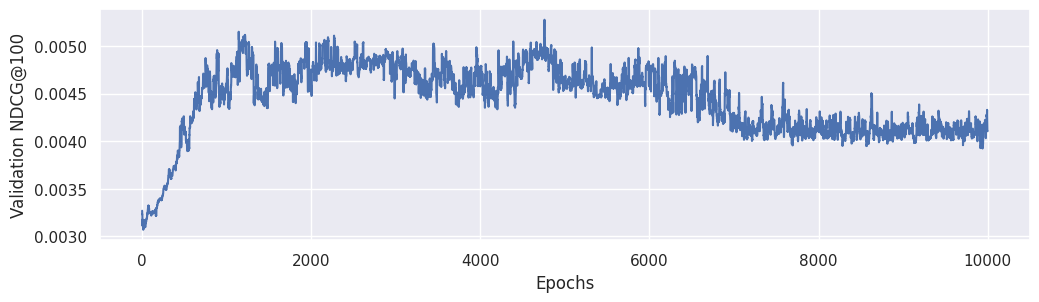

In [385]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

##### Testing

In [386]:
test_data_tr, test_data_te = load_valid_data(
    os.path.join(dir, 'test_train.csv'),
    os.path.join(dir, 'test_test.csv'))

In [387]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)
batch_size_test = 2000

In [388]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()

In [389]:
chkpt_dir = '/content/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /content/VAE_anneal200.0K_cap2.0E-01/I-100-80-100-I


In [390]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=99))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

In [391]:
print("Test NDCG@100= mean:%.5f , std:(%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20= mean: %.5f , std:(%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50= mean: %.5f , std: (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100= mean:0.00552 , std:(0.00099)
Test Recall@20= mean: 0.00625 , std:(0.00174)
Test Recall@50= mean: 0.01375 , std: (0.00259)


#### Train a Multi-DAE

In [352]:
p_dims = [200, n_items]

In [353]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=100)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [354]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))

In [355]:
log_dir = '/content/DAE/{}'.format(arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /content/DAE/I-200-I


In [356]:
chkpt_dir = '/content/DAE/{}'.format(arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir)

print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /content/DAE/I-200-I


In [357]:
n_epochs = 10000

In [358]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    for epoch in tqdm(range(n_epochs)):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = training_data[idxlist[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')

            feed_dict = {dae.input_ph: X,
                         dae.keep_prob_ph: 0.5}
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum)

        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')

            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))

        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

100%|██████████| 10000/10000 [15:07<00:00, 11.02it/s]


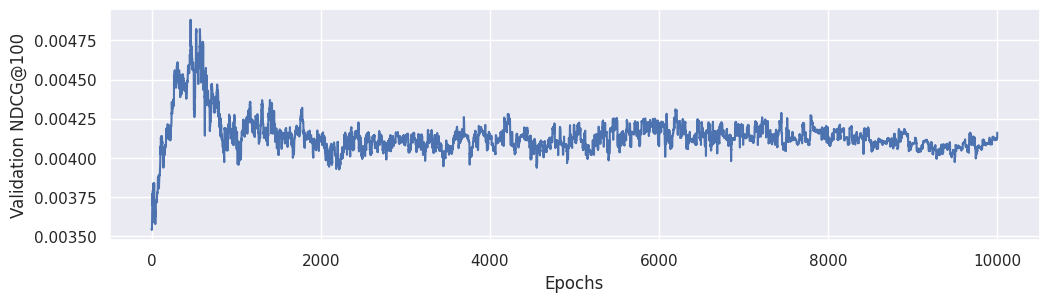

In [359]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

Compute test metrics

In [360]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size)
saver, logits_var, _, _, _ = dae.build_graph()

In [361]:
chkpt_dir = '/content/DAE/{}'.format(arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /content/DAE/I-200-I


In [362]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=99))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

In [363]:
print("Test NDCG@100= mean:%.5f , std:(%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20= mean: %.5f , std:(%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50= mean: %.5f , std: (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.00552 (0.00093)
Test Recall@20=0.00725 (0.00188)
Test Recall@50=0.01475 (0.00268)
